In [14]:
import zarr
import xarray as xr
import dask.array as da
import numpy as np

# Path to your Zarr store
zarr_path = r"brain_epilepsy.zarr"

# Open the Zarr file with xarray
ds = xr.open_zarr(zarr_path)

ds

<xarray.Dataset>
Dimensions:  (c: 8795, z: 1, y: 273, x: 657)
Dimensions without coordinates: c, z, y, x
Data variables:
    0        (c, z, y, x) float32 dask.array<chunksize=(1000, 1, 256, 256), meta=np.ndarray>
Attributes:
    bruker:       {'frame_count': 48797, 'source': 'C:\\Users\\tvisv\\OneDriv...
    multiscales:  [{'axes': ['c', 'z', 'y', 'x'], 'datasets': [{'path': '0'}]...

In [ ]:
zarr_group = zarr.open_group(zarr_path, mode='r')
print(zarr_group.tree())



/
 ├── 0 (8795, 1, 273, 657) float32
 └── labels
     ├── common_mass_axis (13064015,) float32
     ├── lengths
     │   └── 0 (1, 1, 273, 657) uint32
     └── mzs
         └── 0 (8795, 1, 273, 657) uint32


In [ ]:
import zarr
import numpy as np
from collections import Counter
import plotly.express as px

def plot_mz_distribution_interactive(zarr_path):
    """
    Plot an interactive distribution of m/z values in a Zarr file using Plotly.

    Parameters:
    - zarr_path (str): Path to the Zarr file.
    """
    # Open the Zarr group
    zarr_group = zarr.open_group(zarr_path, mode="r")
    
    # Load the m/z data
    mzs = zarr_group['labels/common_mass_axis'][:]  # Assuming m/z data is stored here

    # Flatten the array and remove NaN values and zeros
    flat_mzs = mzs.ravel()
    valid_mzs = flat_mzs[(~np.isnan(flat_mzs)) & (flat_mzs != 0.0)]
    
    # Count the frequencies of m/z values
    counts = Counter(valid_mzs)
    
    # Prepare data for the plot
    mz_values = np.array(list(counts.keys()))
    mz_frequencies = np.array(list(counts.values()))
    
    # Create an interactive plot using Plotly
    fig = px.scatter(
        x=mz_values, 
        y=mz_frequencies, 
        title="Frequency Distribution of m/z Values",
        labels={"x": "m/z Value", "y": "Frequency"},
        log_y=True,  # Logarithmic scale for better visibility of frequency range
    )
    fig.update_traces(marker=dict(size=3, color='skyblue'), mode='markers')
    fig.update_layout(
        xaxis_title="m/z Value index",
        yaxis_title="Frequency (Log Scale)",
        template="plotly_white",
    )
    fig.show()

# Path to your Zarr file
zarr_path = r"C:\Users\tvisv\Downloads\MSIConverter\brain_epilepsy.zarr"

# Plot the interactive distribution
plot_mz_distribution_interactive(zarr_path)


[########################################] | 100% Completed | 747.11 ms
Smallest difference: 3.0517578125e-05
Largest difference: 0.0076904296875
Most common difference: (6.1035156e-05, 8214042)


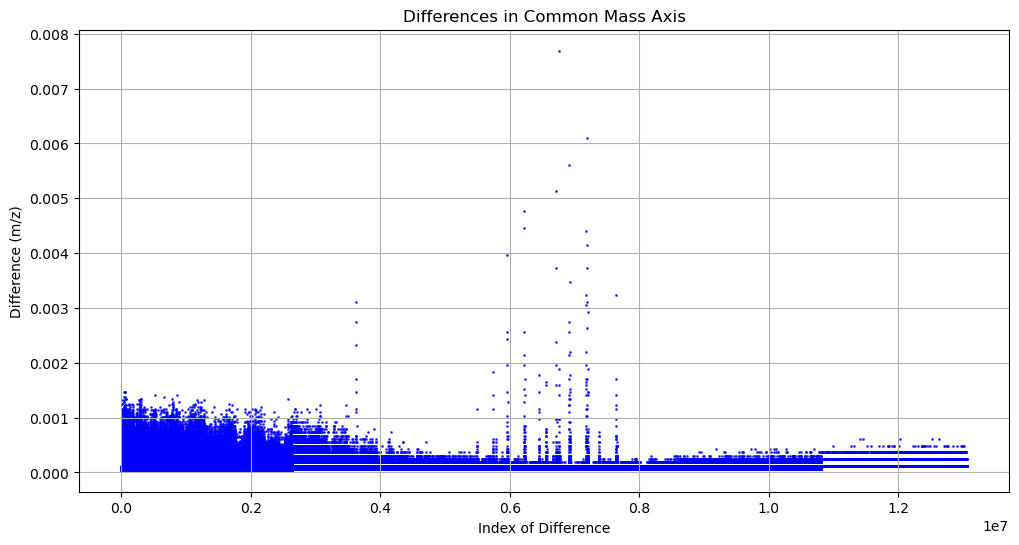

In [2]:
import zarr
import numpy as np
import dask.array as da
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
import dask
from collections import Counter

def plot_common_mass_axis_differences(zarr_path, max_points=100_000_000):
    """
    Plot the differences in the common mass axis stored in a Zarr file using Dask and Matplotlib.

    Parameters:
    - zarr_path (str): Path to the Zarr file.
    - max_points (int): Maximum number of points to plot (downsample if necessary).
    """
    # Open the Zarr group
    zarr_group = zarr.open_group(zarr_path, mode="r")
    
    # Load the common mass axis as a Dask array
    common_mass_axis = da.from_zarr(zarr_group['labels/common_mass_axis'])
    
    # Compute differences lazily
    differences = da.diff(common_mass_axis)
    
    # Compute indices lazily
    indices = da.arange(differences.shape[0])
    
    # Trigger computation with a progress bar and convert to NumPy arrays
    with ProgressBar():
        indices_np, differences_np = dask.compute(indices, differences)
    # Print the smallest and largest differences
    smallest_diff = differences_np.min()
    largest_diff = differences_np.max()
    diff_counts = Counter(differences_np)
    most_common_diff = diff_counts.most_common(1)[0]
    print(f"Smallest difference: {smallest_diff}")
    print(f"Largest difference: {largest_diff}")
    print(f"Most common difference: {most_common_diff}")

    # Downsample data if necessary
    if len(indices_np) > max_points:
        step = len(indices_np) // max_points
        indices_np = indices_np[::step]
        differences_np = differences_np[::step]

    # Plot using Matplotlib
    plt.figure(figsize=(12, 6))
    plt.scatter(indices_np, differences_np, s=1, color="blue", alpha=0.7)
    plt.title("Differences in Common Mass Axis")
    plt.xlabel("Index of Difference")
    plt.ylabel("Difference (m/z)")
    plt.grid(True)



    plt.show()


if __name__ == "__main__":
    # Example usage
    zarr_path = r"C:\Users\tvisv\Downloads\MSIConverter\brain_epilepsy.zarr"  # Replace with the actual path to your Zarr file
    plot_common_mass_axis_differences(zarr_path)


In [3]:
from collections import Counter

def analyze_duplicates(zarr_path):
    # Open the Zarr group and load the common mass axis
    zarr_group = zarr.open_group(zarr_path, mode="r")
    common_mass_axis = da.from_zarr(zarr_group['labels/common_mass_axis']).compute()

    # Count occurrences
    unique, counts = np.unique(common_mass_axis, return_counts=True)
    duplicate_counts = counts[counts > 1]

    # Analyze duplicates
    print(f"Total duplicates: {len(duplicate_counts)}")
    print(f"Max duplicate count: {duplicate_counts.max()}")
    print(f"Most common duplicate count: {Counter(duplicate_counts).most_common(1)}")
    print(f"Top 10 duplicate counts: {Counter(duplicate_counts).most_common(10)}")

analyze_duplicates(zarr_path)


Total duplicates: 0


ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
import zarr
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_heatmap_and_mass_spectrum(zarr_path, pixel_indices, mz_min=100, mz_max=250):
    """
    Plot a combined view of summed mass spectrum and heatmap for selected pixels.

    Parameters:
    - zarr_path (str): Path to the Zarr file.
    - pixel_indices (list of tuples): List of (x, y) pixel indices to plot.
    - mz_min (float): Minimum m/z value for the plots.
    - mz_max (float): Maximum m/z value for the plots.
    """
    # Open the Zarr group
    zarr_group = zarr.open_group(zarr_path, mode="r")

    # Load m/z, intensity, and lengths data
    mzs = zarr_group['labels/mzs/0']  # m/z values
    intensities = zarr_group['0']  # Intensity values
    lengths = zarr_group['labels/lengths/0'][:]  # Valid m/z counts per pixel

    # Initialize a set to combine all unique m/z values
    combined_mass_axis = set()

    # Extract unique m/z values for each pixel
    pixel_mzs_and_intensities = []
    for x, y in pixel_indices:
        # Get the number of valid m/z values for the pixel
        length = lengths[0, 0, y, x]

        # Extract the m/z values and intensities for the pixel
        pixel_mzs = mzs[:length, 0, y, x]
        pixel_intensities = intensities[:length, 0, y, x]

        # Add to the combined mass axis
        combined_mass_axis.update(pixel_mzs)

        # Store for alignment later
        pixel_mzs_and_intensities.append((pixel_mzs, pixel_intensities))

    # Convert to a sorted numpy array and crop to the desired m/z range
    combined_mass_axis = np.array(sorted(combined_mass_axis))
    cropped_mass_axis = combined_mass_axis[(combined_mass_axis >= mz_min) & (combined_mass_axis <= mz_max)]

    # Align intensities to the combined cropped mass axis
    heatmap_data = []
    summed_intensities = np.zeros_like(cropped_mass_axis, dtype=float)
    for pixel_mzs, pixel_intensities in pixel_mzs_and_intensities:
        # Create a mapping of m/z to intensity for the pixel
        mz_to_intensity = dict(zip(pixel_mzs, pixel_intensities))

        # Align intensities to the combined cropped mass axis
        aligned_intensities = [mz_to_intensity.get(mz, 0) for mz in cropped_mass_axis]
        heatmap_data.append(aligned_intensities)

        # Sum intensities for the mass spectrum
        summed_intensities += np.array(aligned_intensities)

    # Convert heatmap data to a 2D NumPy array
    heatmap_data = np.array(heatmap_data)

    # Apply logarithmic transformation for the heatmap
    log_heatmap_data = np.log1p(heatmap_data)

    # Create subplots: Top for summed mass spectrum, Bottom for heatmap
    fig = make_subplots(
        rows=2, cols=1,
        shared_xaxes=True,
        vertical_spacing=0.1,
        row_heights=[0.3, 0.7],
        subplot_titles=("Summed Mass Spectrum", "Heatmap (Log Scale)")
    )

    # Add summed mass spectrum trace
    fig.add_trace(
        go.Scatter(
            x=cropped_mass_axis,
            y=summed_intensities,
            mode='lines',
            name="Summed Mass Spectrum",
            line=dict(width=1.5)
        ),
        row=1, col=1
    )

    # Add heatmap
    fig.add_trace(
        go.Heatmap(
            z=log_heatmap_data,
            x=cropped_mass_axis,
            y=[f"Pixel {i+1}" for i in range(len(pixel_indices))],
            coloraxis="coloraxis"
        ),
        row=2, col=1
    )

    # Update layout
    fig.update_layout(
        title_text="Summed Mass Spectrum and Heatmap View",
        coloraxis=dict(colorscale="Viridis"),
        xaxis=dict(title="Mass Axis (m/z)", range=[mz_min, mz_max]),
        xaxis2=dict(title="Mass Axis (m/z)"),
        yaxis=dict(title="Summed Intensity"),
        yaxis2=dict(title="Pixels"),
        template="plotly_white",
        height=800
    )

    fig.show()

# Path to your Zarr file
zarr_path = r"C:\Users\tvisv\Downloads\MSIConverter\pea4.zarr"

# Define four pixel indices as (x, y) coordinates
selected_pixels = [(29, 30),(30, 30), (31, 30), (32, 30), (33, 30)]

# Plot the heatmap and summed mass spectrum
plot_heatmap_and_mass_spectrum(zarr_path, selected_pixels, mz_min=200, mz_max=300)


In [ ]:
import zarr
import numpy as np
import dask
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt


def plot_average_mass_spectrum_dask(zarr_path):
    """
    Compute and plot the average mass spectrum for a Zarr dataset using Dask.

    Parameters:
    - zarr_path (str): Path to the Zarr file.
    """
    # Open the Zarr group
    zarr_group = zarr.open_group(zarr_path, mode="r")

    # Load the common mass axis
    common_mass_axis = zarr_group["labels/common_mass_axis"][:]
    num_mzs = len(common_mass_axis)

    # Load the Zarr datasets as Dask arrays
    mzs_dataset = zarr_group["labels/mzs/0"]
    intensities_dataset = zarr_group["0"]

    # Get the shape of the data
    max_length, _, y_dim, x_dim = mzs_dataset.shape

    # Function to process a single pixel
    def process_pixel(y, x):
        # Extract the m/z indices and intensities for the pixel
        mz_indices = mzs_dataset[:, 0, y, x].compute()
        intensities_pixel = intensities_dataset[:, 0, y, x].compute()

        # Filter out zeros (if necessary, assuming padding exists)
        valid = mz_indices > 0
        mz_indices = mz_indices[valid]
        intensities_pixel = intensities_pixel[valid]

        # Accumulate intensities for the pixel
        pixel_spectrum = np.zeros(num_mzs, dtype=np.float64)
        np.add.at(pixel_spectrum, mz_indices, intensities_pixel)
        return pixel_spectrum

    # Create tasks for all pixels
    tasks = [
        dask.delayed(process_pixel)(y, x)
        for y in range(y_dim)
        for x in range(x_dim)
    ]

    # Aggregate the spectra across all pixels
    with ProgressBar():
        total_spectrum = dask.delayed(sum)(tasks).compute()

    # Normalize by the total number of pixels
    average_spectrum = total_spectrum / (y_dim * x_dim)

    # Plot the average mass spectrum
    plt.figure(figsize=(12, 6))
    plt.plot(common_mass_axis, average_spectrum, label="Average Spectrum")
    plt.xlabel("m/z")
    plt.ylabel("Average Intensity")
    plt.title("Average Mass Spectrum")
    plt.legend()
    plt.show()


# Example usage
# zarr_path = "path_to_your_zarr_file.zarr"  # Replace with the actual path to your Zarr file
plot_average_mass_spectrum_dask(zarr_path)


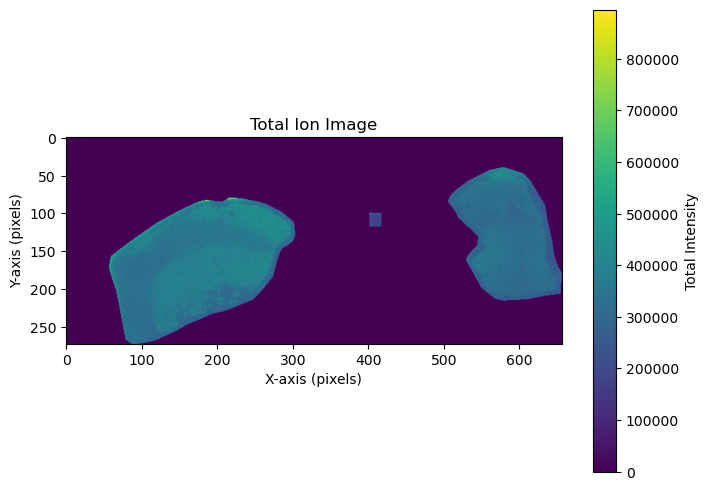

In [3]:
import dask.array as da
import zarr
import matplotlib.pyplot as plt


# Open the Zarr file directly with zarr
zarr_group = zarr.open_group(zarr_path, mode='r')

# Load intensity array as Dask array
intensities = da.from_zarr(zarr_group['0'])  # Intensity array (c, z, y, x)

# Sum intensities along the m/z axis (first axis: `c`)
total_ion_image = intensities.sum(axis=0)  # Resulting shape: (z, y, x)

# Compute the total ion image
total_ion_image = total_ion_image.compute()

# Plot the total ion image (assuming 2D for a single z-plane)
plt.figure(figsize=(8, 6))
plt.imshow(total_ion_image[0], cmap='viridis')  # Select the first z-plane
plt.colorbar(label='Total Intensity')
plt.title('Total Ion Image')
plt.xlabel('X-axis (pixels)')
plt.ylabel('Y-axis (pixels)')
plt.show()


In [42]:
import zarr
import dask.array as da
import numpy as np
import matplotlib.pyplot as plt
from dask.diagnostics import ProgressBar


def plot_mass_dimension_lengths_dask(zarr_path):
    """
    Use Dask to compute the lengths of the mass dimension for each pixel in a Zarr dataset
    to determine if padding is used, and visualize the results.

    Parameters:
    - zarr_path (str): Path to the Zarr file.
    """
    # Open the Zarr group
    zarr_group = zarr.open_group(zarr_path, mode="r")

    # Load the intensities and lengths datasets as Dask arrays
    intensities = da.from_zarr(zarr_group["0"])  # Shape: (8795, 1, 273, 657)
    lengths = da.from_zarr(zarr_group["labels/lengths/0"]).squeeze()  # Shape: (273, 657)

    # Ensure chunk compatibility
    lengths = lengths.rechunk(intensities.chunks[2:])  # Match pixel grid chunks

    # Compute effective lengths for each pixel
    def compute_effective_lengths(block_lengths, block_intensities):
        effective_lengths = np.zeros_like(block_lengths, dtype=np.uint32)
        for idx, length in np.ndenumerate(block_lengths):
            if length > 0:
                pixel_data = block_intensities[:length, 0, idx[0], idx[1]]
                effective_lengths[idx] = np.count_nonzero(pixel_data)
        return effective_lengths

    # Apply the function block-wise
    effective_lengths = da.map_blocks(
        compute_effective_lengths,
        lengths,
        intensities,
        dtype=np.uint32,
    )

    # Compute the effective lengths
    with ProgressBar():
        effective_lengths_np = effective_lengths.compute()

    # Flatten the effective lengths and filter out zero values
    flattened_lengths = effective_lengths_np.ravel()
    non_zero_lengths = flattened_lengths[flattened_lengths > 0]

    # Plot histogram of effective lengths
    plt.figure(figsize=(12, 6))
    plt.hist(non_zero_lengths, bins=50, color="skyblue", edgecolor="black", alpha=0.7)
    plt.xlabel("Effective Length (Non-Zero Values in Mass Dimension)")
    plt.ylabel("Frequency")
    plt.title("Distribution of Effective Mass Dimension Lengths")
    plt.grid(axis="y", alpha=0.75)
    plt.show()

    # Print statistics
    print(f"Total pixels with data: {len(non_zero_lengths)}")
    print(f"Minimum effective length: {np.min(non_zero_lengths)}")
    print(f"Maximum effective length: {np.max(non_zero_lengths)}")
    print(f"Average effective length: {np.mean(non_zero_lengths):.2f}")
    print(f"Median effective length: {np.median(non_zero_lengths):.2f}")



# Usage example
zarr_path = "brain_epilepsy.zarr"  # Replace with the actual path
plot_mass_dimension_lengths_dask(zarr_path)


[                                        ] | 0% Completed | 631.00 us

[########################################] | 100% Completed | 20.69 ss


IndexError: tuple index out of range